# 注意力机制

## 注意力提示

### 1.生物学中的注意力提示

+ 非自主性提示————基于环境中物体的突出性和易见性
    
    例如：你在一群白色的狗中看到了一只黑色的狗

+ 自主性提示————收到认知和意识的控制
    
    例如：不管什么颜色的狗，你想拿一只小小的、毛多的狗


### 2.查询、键和值

如何通过注意力的方式，用神经网络来设计注意力机制的框架呢？

首先考虑一种简单的情况——只有非自主性提示。要想将选择偏向于感官输入，我们可以简单的使用参数化的全连接层（例如选择的时候，谁的概率大就选谁）。**因此，“是否包含自主性提示”将注意力机制与全连接层或汇聚层区别开来**



观察下面这个框架：

<img src = "photo/qkv.svg">


+ 查询：自主性提示

+ 键：非自主性提示

+ 值：感官输入

给定任何查询，注意力机制通过注意力汇聚（attention pooling） 将选择引导至感官输入（sensory inputs，例如中间特征表示）

更通俗的解释，每个值都与一个键（key）配对， 这可以想象为感官输入的非自主提示。 上图所示，我们可以设计注意力汇聚， 以便给定的查询（自主性提示）可以与键（非自主性提示）进行匹配， 这将引导得出最匹配的值（感官输入）。

### 3.注意力可视化

In [1]:
import torch
from d2l import torch as d2l

def show_heatmaps(matrices,xlabel,ylabel,titles = None,figsize=(2.5,2.5),cmap="Reds"):
    """显示矩阵热图"""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6); 
    

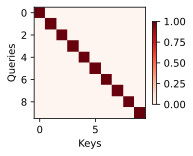

In [2]:
# 下面我们使用一个简单的例子进行演示。 
# 在本例子中，仅当查询和键相同时，注意力权重为1，否则为0。

attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

## 注意力汇聚——Nadaraya-Watson 核回归

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

### 1.生成数据集

给定x预测$\hat y$

$$y_i = 2\sin(x_i) + x_i^{0.8} + \epsilon,$$

In [5]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train)*5)  # 样本进行排序，便于更好的展示注意力模式

print(x_train)

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0,0.5,(n_train,)) # 训练样本输出
x_test = torch.arange(0,5,0.1)  # 测试样本
y_truth = f(x_test)
n_test = len(x_test)        # 测试样本数量
n_test



tensor([0.0604, 0.1060, 0.1263, 0.1422, 0.1694, 0.1773, 0.3818, 0.3962, 0.4976,
        0.6243, 0.6243, 0.8442, 0.8626, 1.0152, 1.3058, 1.3276, 1.6151, 1.6859,
        1.7935, 1.9268, 1.9419, 2.2083, 2.5210, 2.5274, 2.7096, 2.7126, 2.9959,
        3.0540, 3.1004, 3.1078, 3.2699, 3.4798, 3.4922, 3.5151, 3.7255, 3.7410,
        3.9838, 3.9905, 4.0719, 4.0899, 4.2083, 4.2601, 4.3619, 4.3951, 4.5811,
        4.6931, 4.7197, 4.7360, 4.7484, 4.9854])


50

In [6]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

### 2.平均汇聚

使用最简单的估计其来解决回归问题：

$$f(x) = \frac{1}{n} \sum_{i=1}^x y_i$$


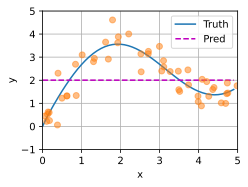

In [7]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

可以看到预测相差很大


### 3.非参数注意力汇聚

显然，平均汇聚层忽略了输入x，下面的模型根据输入的位置对输出$y_i$进行加权

$$
f(x) = \sum_{i=1}^n \frac{K(x-x_i)}{\sum_{j=1}^n K(x-x_j)} y_i
$$(K是核函数，评估距离的函数)

受此启发，下面是一个更加通用的注意力汇聚公式：

$$
f(x) = \sum_{i=1}^n \alpha (x,x_i)y_i
$$

其中，x是查询，$(x_i,y_i)$是键值对。注意力汇聚是$y_i$的加权平均。

将查询x和键$x_i$之间的关系建模为 注意力权重（attention weight）$\alpha (x,x_i)$,这个权重将分配给每一个对应的值$y_i$

对于任何查询，模型在所有键值对注意力权重都是一个有效的概率分布： 它们是非负的，并且总和为1。

给定x（测试样本），$x_i$（训练样本），$y_i$（训练标签）



在这里我们选择一个高斯核：

$K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2}).$

将高斯核带入可得：

$$
\begin{split}\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}\end{split}

$$

如果一个键$x_i$越是接近给定的查询x，那么分配给键对应值$y_i$的注意力权重就越大（$e^{-x}$）。也就获得了更多的注意力

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
        [0.2000, 0.2000, 0.2000,  ..., 0.2000, 0.2000, 0.2000],
        ...,
        [4.7000, 4.7000, 4.7000,  ..., 4.7000, 4.7000, 4.7000],
        [4.8000, 4.8000, 4.8000,  ..., 4.8000, 4.8000, 4.8000],
        [4.9000, 4.9000, 4.9000,  ..., 4.9000, 4.9000, 4.9000]]) 50
tensor([[6.9080e-02, 6.8818e-02, 6.8656e-02,  ..., 9.3254e-07, 8.7920e-07,
         2.7745e-07],
        [6.5483e-02, 6.5534e-02, 6.5512e-02,  ..., 1.4109e-06, 1.3319e-06,
         4.3038e-07],
        [6.1861e-02, 6.2191e-02, 6.2297e-02,  ..., 2.1274e-06, 2.0107e-06,
         6.6532e-07],
        ...,
        [1.2054e-06, 1.4883e-06, 1.6333e-06,  ..., 5.6909e-02, 5.6879e-02,
         5.4674e-02],
        [8.0022e-07, 9.9248e-07, 1.0914e-06,  ..., 6.0297e-02, 6.0341e-02,
         5.9392e-02],
        [5.2937e-07, 6.5957e-07, 7.2677e-07,  ..., 6.3667e-02, 6.3791e-02,
         6.4294e-02]])
ten

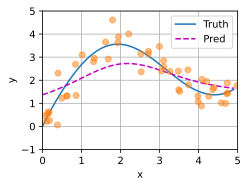

In [15]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape(-1,n_train)
print(X_repeat,len(X_repeat[0]))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat-x_train)**2 /2,dim=1)  # 每一行都是一样的，减去x_train变成了每个x与x_train的“距离”，在进行softmax操作
print(attention_weights)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
print(y_hat)
plot_kernel_reg(y_hat)

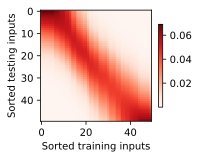

In [16]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

 这里测试数据的输入相当于查询，而训练数据的输入相当于键。 因为两个输入都是经过排序的，因此由观察可知“查询-键”对越接近， 注意力汇聚的注意力权重就越高。

### 4.带参数的注意力汇聚

加入参数w来控制高斯核，

$$\begin{split}\begin{aligned}f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_j)w)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}\end{split}$$

In [23]:
## 定义模型

class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,),requires_grad=True))
        
    def forward(self,queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1,keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)
        

In [24]:
# 训练：
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

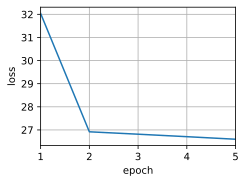

In [25]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

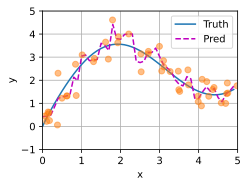

In [26]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

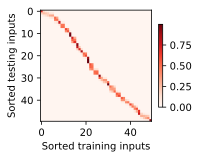

In [27]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')